## Import Modules

In [1]:
# import tensorflow_datasets as tfds
import tensorflow as tf
import os
import math
import numpy as np
from attention import (
    PositionalEncoding,
    MultiHeadAttentionSubLayer,
    FeedForwardNetworkSubLayer,
    Transformer,
    Encoder,
)
from custom_smoothing import Smoothing
from custom_scaler import CustomScaler
from custom_data_gen import CustomDataGenSeqUnCached, CustomDataGenFlowFromFile, EvaluationDataGen
from custom_callback import CustomCallback
import matplotlib.pyplot as plt
import time
import pandas as pd
from tensorflow.keras.metrics import RootMeanSquaredError, CosineSimilarity
from IPython.display import Image, display
from tensorflow.keras.metrics import RootMeanSquaredError

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))
plt.style.use("fivethirtyeight")


Num GPUs Available:  1


In [4]:
batch_size = 64


# single speaker
# data_dir = "/home/alkhemi/Documents/thesis/npy_data_mfcc39_landmark107_s19/"
# single_or_multi = "single"

# # multi speaker
data_dir = "/home/alkhemi/Documents/thesis/npy_data_mfcc39_landmark107/"
single_or_multi = "multi"

# data_dir = "/home/alkhemi/Documents/thesis/npy_data_mfcc39_landmark107_smallset/"
# single_or_multi = "small"

train_dir = data_dir+"train/"
test_dir = data_dir+"test/"

X_feature_size = 39
Y_feature_size = 107
x_num_pre =11
x_num_post = 2
y_num_pre = 11
y_num_post = 2
# x_pad_value= None
# y_pad_value= None
x_pad_value= np.array([-300]+[0.0]*38)
y_pad_value= np.zeros((107,), dtype=float)
x_shift = 0
y_shift = 0
x_seq_len = x_num_pre + x_num_post + 1
y_seq_len = y_num_pre + y_num_post + 1
X_scaler = CustomScaler(X_feature_size)
Y_scaler = CustomScaler(Y_feature_size)
X_scaler.from_csv(train_dir+"x_scaler_coef.csv")
Y_scaler.from_csv(train_dir+"y_scaler_coef.csv")
model_dir = "/home/alkhemi/Documents/thesis/saved_model/"


## Batch Generator


In [5]:
with tf.device("/gpu:0"):

    # cached raw data but seq and batch data is calculated on the fly/uncached
    train_data_generator = CustomDataGenSeqUnCached(
        train_dir,
        batch_size,
        x_num_pre,
        x_num_post,
        y_num_pre,
        y_num_post,
        X_scaler,
        Y_scaler,
        x_shift=x_shift,
        y_shift=y_shift,
    )
    test_data_generator = CustomDataGenSeqUnCached(
        test_dir,
        batch_size,
        x_num_pre,
        x_num_post,
        y_num_pre,
        y_num_post,
        X_scaler,
        Y_scaler,
        x_shift=x_shift,
        y_shift=y_shift,
    )

    # read file in each batch
    # train_data_generator = CustomDataGenFlowFromFile(train_dir,batch_size,x_num_pre,x_num_post,y_num_pre,y_num_post,X_scaler,Y_scaler)
    # test_data_generator = CustomDataGenFlowFromFile(test_dir,batch_size,x_num_pre,x_num_post,y_num_pre,y_num_post,X_scaler,Y_scaler)

# 0-0-0-0 1067971
# 11-2-11-2 1223958
# 11-2-0-0 1223958
# 4425982

datapoints 989971


In [ ]:

# train_data_generator.on_epoch_end()
# test_data_generator.on_epoch_end()
# for i in range(test_data_generator.__len__()):
#     data = test_data_generator[i]
#     print(i, data[0], data[1])

# data = train_data_generator[len(train_data_generator)-1]
# print( data[0][0].shape, data[0][1].shape, data[1].shape)


## Metrics

In [ ]:
# with tf.device('/gpu:0'):
#    metrics = [    
            # tf.keras.metrics.RootMeanSquaredError(),
            # tf.keras.metrics.CosineSimilarity(axis=2),
   # ]

## Create Or Load Model

datapoints 4425982
existed


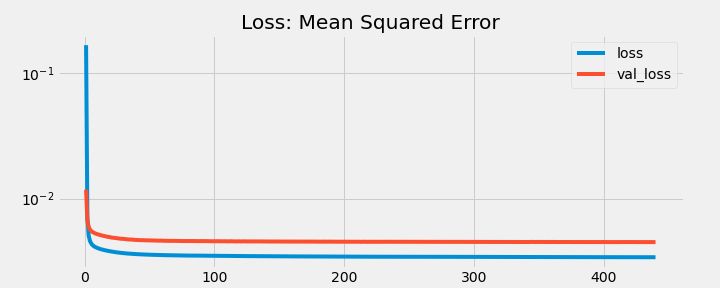

Model: "TransformerEncoder_d64_l1_h8_seq11-2-11-2_multi"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 39)]          0         
_________________________________________________________________
encoder (Encoder)            (None, 14, 64)            52544     
_________________________________________________________________
dense_7 (Dense)              (None, 14, 107)           6955      
Total params: 59,499
Trainable params: 59,499
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/gpu:0'):
  # transformer
  d_model = 64
  num_heads = 8
  dff = 4*d_model
  num_layers = 1
  model_name = f"TransformerEncoder_d{d_model}_l{num_layers}_h{num_heads}_seq{x_num_pre}-{x_num_post}-{y_num_pre}-{y_num_post}_{single_or_multi}"
  input = tf.keras.Input((x_seq_len,X_feature_size), dtype='float32')
  h = Encoder(num_layers=num_layers,d_model=d_model,num_heads=num_heads,dff=dff,maximum_position_encoding=x_seq_len) (input)  
  output = tf.keras.layers.Dense(Y_feature_size, activation='linear') (h)
  model = tf.keras.models.Model(inputs=input,outputs=output, name=model_name)

  # cnn  # Karras 2017
  # filter = 64
  # model_name = f"CNN{filter}_seq{x_num_pre}-{x_num_post}-{y_num_pre}-{y_num_post}_{single_or_multi}"
  # input = tf.keras.Input((x_seq_len,X_feature_size), dtype='float32')
  # x = tf.keras.layers.Reshape((x_seq_len, X_feature_size, 1)) (input)  
  # for i in reversed(range(math.floor(math.log(X_feature_size,2))-1)):
  #   x = tf.keras.layers.Conv2D(filter/(2**i), kernel_size=(1,3), strides =(1,2), activation='relu') (x)
  # seq = x.shape[1]
  # while seq > 1:
  #   if seq > 2:
  #     x = tf.keras.layers.Conv2D(filter, kernel_size=(3,1), strides =(2,1), activation='relu') (x)
  #   else:
  #     x = tf.keras.layers.Conv2D(filter, kernel_size=(2,1), strides =(1,1), activation='relu') (x)
  #   seq = x.shape[1]  
  # x = tf.keras.layers.Reshape((1,filter)) (x)
  # output = tf.keras.layers.Dense(Y_feature_size, activation='linear') (x)
  # model = tf.keras.models.Model(inputs=input,outputs=output, name=model_name)

  # MLP
  # unit = 64
  # layer = 3
  # model_name = f"MLP_u{unit}_l{layer}_seq{x_num_pre}-{x_num_post}-{y_num_pre}-{y_num_post}_{single_or_multi}"
  # input = tf.keras.Input((x_seq_len,X_feature_size), dtype='float32')  
  # x =  tf.keras.layers.Dense(unit, activation='tanh') (input)
  # for _ in range(layer-1):
  #   x =  tf.keras.layers.Dense(unit, activation='tanh') (x)
  # output = tf.keras.layers.Dense(Y_feature_size, activation='linear') (x)
  # model = tf.keras.models.Model(inputs=input,outputs=output, name=model_name)

  # LSTM
  # unit = 64
  # layer = 1
  # model_name = f"LSTM_u{unit}_l{layer}_seq{x_num_pre}-{x_num_post}-{y_num_pre}-{y_num_post}_{single_or_multi}"
  # input = tf.keras.Input((x_seq_len,X_feature_size), dtype='float32')  
  # x =  tf.keras.layers.LSTM(units=unit,activation='tanh', return_sequences=True) (input)
  # for i in range(layer-1):
  #   x =  tf.keras.layers.LSTM(units=unit,activation='tanh', return_sequences=True) (x)
  # output = tf.keras.layers.Dense(Y_feature_size, activation='linear') (x)
  # model = tf.keras.models.Model(inputs=input,outputs=output, name=model_name)
  
  save_dir = model_dir+model_name+"/"
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)

  models_weights = [item for item in os.listdir(save_dir) if item.endswith('.h5')]
  models_weights.sort()

  if(len(models_weights)>0):
    print("existed")
    display(Image(os.path.join(save_dir,"train-mse.png")))
    model.load_weights(save_dir+models_weights[-1])


  tf.keras.utils.plot_model(model, os.path.join(save_dir,"layers.png"), show_shapes=True, show_layer_names=False, expand_nested=True)
  model.summary()



## Train

Epoch 1/50
69155/69155 [==============================] - 531s 8ms/step - loss: 0.0034 - val_loss: 0.0045


<Figure size 432x288 with 0 Axes>

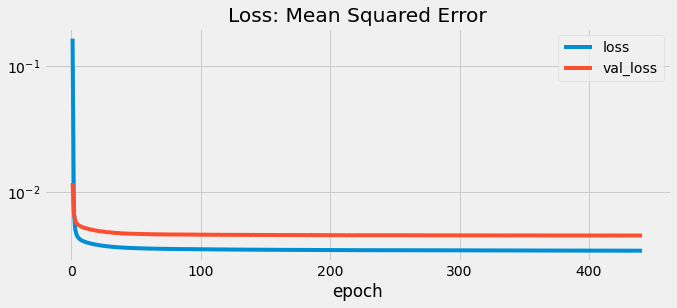

time elapsed: 533.5705435276031
Epoch 2/50
69155/69155 [==============================] - 518s 7ms/step - loss: 0.0034 - val_loss: 0.0045


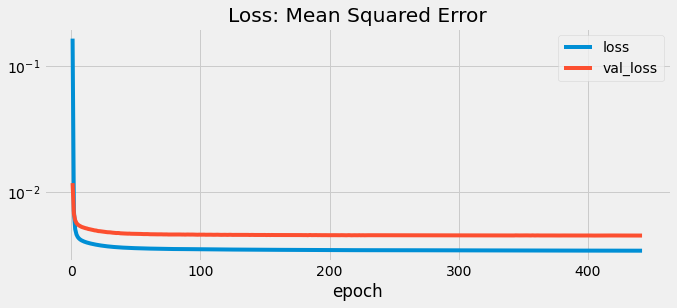

time elapsed: 1052.51002907753
Epoch 3/50
69155/69155 [==============================] - 520s 8ms/step - loss: 0.0034 - val_loss: 0.0045


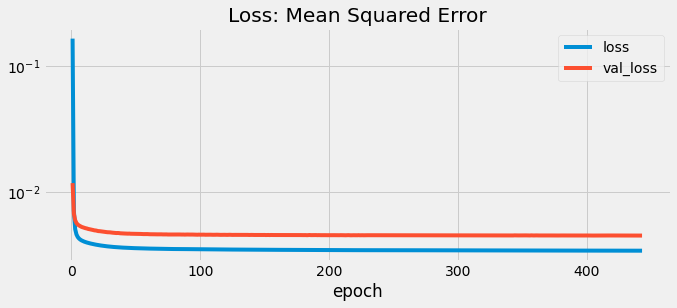

time elapsed: 1573.0683104991913
Epoch 4/50
69155/69155 [==============================] - 524s 8ms/step - loss: 0.0034 - val_loss: 0.0045


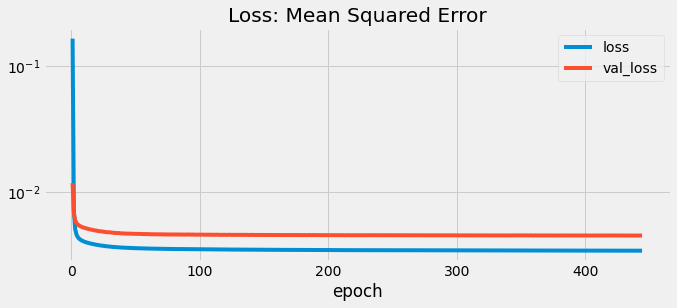

time elapsed: 2097.6659123897552
Epoch 5/50
69155/69155 [==============================] - 521s 8ms/step - loss: 0.0034 - val_loss: 0.0045


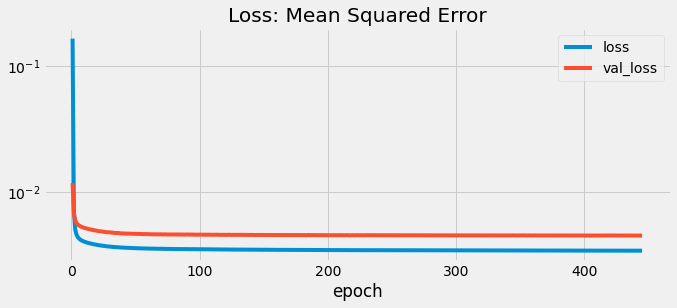

time elapsed: 2619.7872767448425
Epoch 6/50
69155/69155 [==============================] - 524s 8ms/step - loss: 0.0034 - val_loss: 0.0045


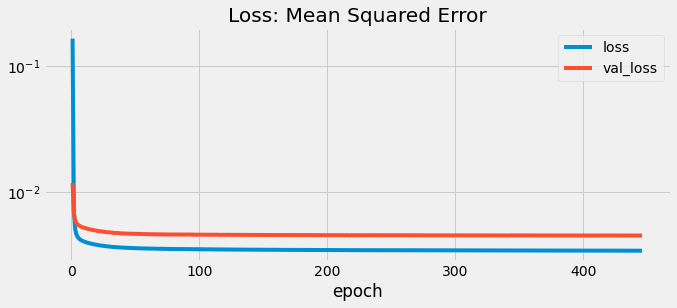

time elapsed: 3144.681347131729
Epoch 7/50
69152/69155 [============================>.] - ETA: 0s - loss: 0.0034

In [7]:
# train_data_generator.on_epoch_end()
# test_data_generator.on_epoch_end()
models_weights = [item for item in os.listdir(save_dir) if item.endswith(".h5")]
models_weights.sort()
if len(models_weights) > 0:
    history_df = pd.read_csv(
        [
            os.path.join(save_dir, item)
            for item in os.listdir(save_dir)
            if item.endswith("history.csv")
        ][0]
    )
    last_epoch = len(history_df)
else:
    last_epoch = 0

alpha = 2e-7

decay_rate = 0.02


def step_decay(epoch):
    return alpha / (1 + decay_rate * (last_epoch + epoch))


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="mse",
    # metrics=metrics,
)

# train_gen = tf.keras.utils.OrderedEnqueuer(train_data_generator())
# test_gen = tf.keras.utils.OrderedEnqueuer(test_data_generator())


def ordered_gen(sequence, workers):
    enq = tf.keras.utils.OrderedEnqueuer(sequence)
    enq.start(workers=workers)
    gen = enq.get()
    while True:
        yield next(gen)

with tf.device("/gpu:0"):
    history = model.fit(
        # multiprocessing fast
        train_data_generator,
        validation_data=test_data_generator,
        # ordered slow
        # ordered_gen(train_data_generator,4),
        # validation_data=ordered_gen(test_data_generator,4),
        epochs=50,
        callbacks=[
            tf.keras.callbacks.LearningRateScheduler(step_decay),
            CustomCallback(model_name=model_name, save_dir=save_dir),
        ],
        verbose=1,
        steps_per_epoch=len(train_data_generator),
        validation_steps =len(test_data_generator)
    )

print("loss", history.history["loss"][-1])
print("val_loss", history.history["val_loss"][-1])

## Evaluation

In [4]:
eval_data_generator = EvaluationDataGen(
        test_dir,
        X_scaler,
        Y_scaler,
    )

datapoints 6000


In [9]:
for i in range(len(eval_data_generator)):
    x,y=eval_data_generator.getitem_sequence(i,11,2,0,0)
    if x.shape[0] != y.shape[0]:
        print(x.shape,y.shape)

In [19]:
 
# cari best model
history_df = pd.read_csv([os.path.join(save_dir,item) for item in os.listdir(save_dir) if item.endswith('history.csv')][0])
min_val_loss = history_df["val_loss"].min()
# print("best val_loss:",f'{min_val_loss:0.4E}')
best_model_index = history_df["val_loss"].tolist().index(min_val_loss)
best_model_index = -1

models_weights = [item for item in os.listdir(save_dir) if item.endswith('.h5')]
models_weights.sort()

model.load_weights(os.path.join(save_dir,models_weights[best_model_index]))
print("model:",models_weights[best_model_index])


batch_count = len(eval_data_generator)
# batch_count = 10
rmse = RootMeanSquaredError(dtype="float64")
delta_rmse = RootMeanSquaredError(dtype="float64")
fft_rmse = RootMeanSquaredError(dtype="float64")
cosim = CosineSimilarity(axis=-1)
t = 0
c = 0


def get_item(idx):
    # return eval_data_generator.getitem_single(idx,x_shift=-2,y_shift=0, trim_pre=11,trim_post=2)
    return eval_data_generator.getitem_sequence(i,11,2,0,0)

# direct
# with tf.device('/cpu:0'): 
#     for i in range(batch_count):
#         x_batch, y_batch_true = get_item(i)
#         c+=len(x_batch)
#         y_batch_pred = np.empty_like(y_batch_true)
#         for j in range(len(x_batch)):         
#             start = time.time()
#             y_batch_pred[j] = np.array(model(x_batch[j:j+1]))
#             t += time.time()-start
#         rmse.update_state(Y_scaler.inverse_scale(y_batch_true), Y_scaler.inverse_scale(y_batch_pred))
#         delta_rmse.update_state(np.diff(Y_scaler.inverse_scale(y_batch_true)), np.diff(Y_scaler.inverse_scale(y_batch_pred)))
        # cosim.update_state(Y_scaler.inverse_scale(y_batch_true), Y_scaler.inverse_scale(y_batch_pred))
        # print("batch", i+1, "of", batch_count, "time:", t, "rmse:", rmse.result().numpy(),"delta_rmse:", delta_rmse.result().numpy(), "cosim:",cosim.result().numpy() ) 
with tf.device('/gpu:0'): 
    for i in range(batch_count):
        x_batch, y_batch_true = get_item(i)
        c+=len(x_batch)
        start = time.time()
        y_batch_pred = np.array(model(x_batch))        
        t += time.time()-start
        rmse.update_state(Y_scaler.inverse_scale(y_batch_true), Y_scaler.inverse_scale(y_batch_pred))
        # yt = Y_scaler.inverse_scale(y_batch_true)
        # yp = Y_scaler.inverse_scale(y_batch_pred)
        # for j in range(Y_feature_size):
        #     fft_rmse.update_state(np.fft.fft(yt[:,0,j]), np.fft.fft(yp[:,0,j]))
        # delta_rmse.update_state(np.diff(Y_scaler.inverse_scale(y_batch_true)), np.diff(Y_scaler.inverse_scale(y_batch_pred)))
        # cosim.update_state(Y_scaler.inverse_scale(y_batch_true), Y_scaler.inverse_scale(y_batch_pred))
        print("batch", i+1, "of", batch_count, "time:", t, "rmse:", rmse.result().numpy(),"fft_rmse:", fft_rmse.result().numpy(), "cosim:",cosim.result().numpy() ) 


##### Sequence with Average/Smoothing #######
# smoothing = Smoothing(y_seq_len,Y_feature_size,0,y_num_pre)
# with tf.device('/cpu:0'): 
#     for i in range(batch_count):
#         x_batch, y_batch_true = get_item(i)
#         c+=len(x_batch)
#         y_batch_pred_smooth = np.empty_like(y_batch_true)
#         smoothing.reset()
#         for j in range(len(x_batch)):                       
#             start = time.time()
#             y_batch_pred_smooth[j] = smoothing(np.array(model(x_batch[j:j+1]))[0])
#             t += time.time()-start            
#         rmse.update_state(Y_scaler.inverse_scale(y_batch_true), Y_scaler.inverse_scale(y_batch_pred_smooth))
#         delta_rmse.update_state(np.diff(Y_scaler.inverse_scale(y_batch_true)), np.diff(Y_scaler.inverse_scale(y_batch_pred_smooth)))
#         cosim.update_state(Y_scaler.inverse_scale(y_batch_true), Y_scaler.inverse_scale(y_batch_pred_smooth))
#         print("batch", i+1, "of", batch_count, "time:", t, "rmse:", rmse.result().numpy(),"delta_rmse:", delta_rmse.result().numpy(), "cosim:",cosim.result().numpy() ) 
# smoothing = Smoothing(y_seq_len,Y_feature_size,1,y_num_pre)
# with tf.device('/gpu:0'): 
#     for i in range(batch_count):
#         x_batch, y_batch_true = get_item(i)
#         c+=len(x_batch)
#         start = time.time()
#         y_batch_pred = np.array(model(x_batch))              
#         y_batch_pred_smooth = np.empty_like(y_batch_true)
#         smoothing.reset()
#         for j in range(len(y_batch_pred_smooth)):
#              y_batch_pred_smooth[j] = smoothing(y_batch_pred[j])                    
#         t += time.time()-start        
#         rmse.update_state(Y_scaler.inverse_scale(y_batch_true), Y_scaler.inverse_scale(y_batch_pred_smooth))
#         # delta_rmse.update_state(np.diff(Y_scaler.inverse_scale(y_batch_true)), np.diff(Y_scaler.inverse_scale(y_batch_pred_smooth)))
#         # cosim.update_state(Y_scaler.inverse_scale(y_batch_true), Y_scaler.inverse_scale(y_batch_pred_smooth))
#         print("batch", i+1, "of", batch_count, "time:", t, "rmse:", rmse.result().numpy(),"delta_rmse:", delta_rmse.result().numpy(), "cosim:",cosim.result().numpy() )      

###### Sequence without smoothing #######
# with tf.device('/cpu:0'): 
#     for i in range(batch_count):
#         x_batch, y_batch_true = get_item(i)
#         c+=len(x_batch)
#         y_batch_pred = np.empty_like(y_batch_true)
#         for j in range(len(x_batch)):                    
#             start = time.time()
#             y_pred = np.array(model(x_batch[j:j+1]))
#             t += time.time()-start            
#             y_batch_pred[j] = y_pred[0,y_num_pre:y_num_pre+1,:]
#         rmse.update_state(Y_scaler.inverse_scale(y_batch_true), Y_scaler.inverse_scale(y_batch_pred))
#         delta_rmse.update_state(np.diff(Y_scaler.inverse_scale(y_batch_true)), np.diff(Y_scaler.inverse_scale(y_batch_pred)))
#         cosim.update_state(Y_scaler.inverse_scale(y_batch_true), Y_scaler.inverse_scale(y_batch_pred))
#         print("batch", i+1, "of", batch_count, "time:", t, "rmse:", rmse.result().numpy(),"delta_rmse:", delta_rmse.result().numpy(), "cosim:",cosim.result().numpy() ) 
# with tf.device('/gpu:0'): 
#     for i in range(batch_count):
#         x_batch, y_batch_true = get_item(i)
#         c+=len(x_batch)
#         start = time.time()
#         y_batch_pred = np.array(model(x_batch))              
#         t += time.time()-start
#         y_batch_pred = y_batch_pred[:,y_num_pre:y_num_pre+1,:]
#         rmse.update_state(Y_scaler.inverse_scale(y_batch_true), Y_scaler.inverse_scale(y_batch_pred))
#         # delta_rmse.update_state(np.diff(Y_scaler.inverse_scale(y_batch_true)), np.diff(Y_scaler.inverse_scale(y_batch_pred)))
#         # cosim.update_state(Y_scaler.inverse_scale(y_batch_true), Y_scaler.inverse_scale(y_batch_pred))
#         print("batch", i+1, "of", batch_count, "time:", t, "rmse:", rmse.result().numpy(),"fft_rmse:", fft_rmse.result().numpy(), "cosim:",cosim.result().numpy() ) 
    
    
print("rmse:", rmse.result().numpy() ,"delta_rmse:", delta_rmse.result().numpy(), "fft_rmse:", fft_rmse.result().numpy(), "cosine_similarity:", cosim.result().numpy())
print("total time:",t,"prediction time:", t*1000/c)

# mlp 300 2e-7 0.02
# rmse: 0.9267311881579916 total_time: 30.28715229034424 prediction_time: 5.0333905942512285 
# rmse: 0.9267352306464867  total_time: 58.54410934448242 prediction_time: 4.966912977623217
# rmse: 0.9222709005790907  total_time: 58.95738959312439 prediction_time: 5.3778933467287

# cnn 350 2e-7 0.02
# rmse: 0.9240704586101409 total_time: 38.77194118499756 prediction_time: 6.31589987783721
 
# lstm 50 2e-7 0.02
# rmse: 0.9239570692609038 total_time: 33.6811203956604 prediction_time: 5.882364648761171 
 
# transformer 440 2e-7 0.02 
# rmse: 0.9258951642756843 total_time: 86.64300346374512 prediction_time: 14.881124915498676
# rmse: 0.9274507788332553 total_time: 109.52961015701294 prediction_time: 15.75525156656901
# rmse: 0.9264158146776477 total_time: 108.57373595237732 prediction_time: 14.783984718900738

model: CNN64_seq11-2-0-0_multi-0350.h5
batch 1 of 6000 time: 0.007996797561645508 rmse: 0.8593764276858066 fft_rmse: 0.0 cosim: 0.0
batch 2 of 6000 time: 0.01589822769165039 rmse: 0.9151054622886959 fft_rmse: 0.0 cosim: 0.0
batch 3 of 6000 time: 0.023337841033935547 rmse: 0.9383524795650231 fft_rmse: 0.0 cosim: 0.0
batch 4 of 6000 time: 0.030318737030029297 rmse: 0.9878785814044744 fft_rmse: 0.0 cosim: 0.0
batch 5 of 6000 time: 0.037586212158203125 rmse: 1.0637458205623231 fft_rmse: 0.0 cosim: 0.0
batch 6 of 6000 time: 0.044146060943603516 rmse: 1.0472072698043686 fft_rmse: 0.0 cosim: 0.0
batch 7 of 6000 time: 0.05025291442871094 rmse: 1.0278251583002849 fft_rmse: 0.0 cosim: 0.0
batch 8 of 6000 time: 0.05634665489196777 rmse: 1.0016731615654002 fft_rmse: 0.0 cosim: 0.0
batch 9 of 6000 time: 0.06250882148742676 rmse: 1.0026341770637222 fft_rmse: 0.0 cosim: 0.0
batch 10 of 6000 time: 0.06967282295227051 rmse: 0.9858652645393443 fft_rmse: 0.0 cosim: 0.0
batch 11 of 6000 time: 0.0761413574

## Grid Search

In [ ]:
seq_exp_df = pd.DataFrame(columns=["d_model","n_layer","x_pre","x_post","rmse","prediction_time"])
seq_exp = []
for i in [64]:
  for j in [1]:
    for k in [8]:
      for l in [1]:
          seq_exp.append([i,j,k,l])

for s in seq_exp:
  print(s)
  x_num_pre = s[2]
  x_num_post = s[3]
  y_num_pre = 0
  y_num_post = 0
  x_seq_len = x_num_pre + x_num_post + 1
  y_seq_len = y_num_pre + y_num_post + 1

  batch_size = 64
  with tf.device('/gpu:0'):
      # khusus transformer
      train_data_generator = CustomDataGenSeqUnCached(train_dir, batch_size, x_num_pre, x_num_post, y_num_pre, y_num_post, X_scaler,Y_scaler, x_pad_value=x_pad_value, y_pad_value=y_pad_value)
      test_data_generator = CustomDataGenSeqUnCached(test_dir, batch_size, x_num_pre, x_num_post, y_num_pre, y_num_post, X_scaler,Y_scaler, x_pad_value=x_pad_value, y_pad_value=y_pad_value)
  

  d_model = s[0]
  num_heads = 8
  dff = 4*d_model
  num_layers = s[1]
  model_name = f"Transformer-Encoder_d{d_model}_l{num_layers}_h{num_heads}_seq{x_num_pre}-{x_num_post}-{y_num_pre}-{y_num_post}_{single_or_multi}"

  save_dir = model_dir+model_name+"/"
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)

  with tf.device('/gpu:0'):
    # Transformer
    input = tf.keras.Input((x_seq_len,X_feature_size), dtype='float32')
    h = Encoder(num_layers=num_layers,d_model=d_model,num_heads=num_heads,dff=dff,maximum_position_encoding=x_seq_len) (input)  
    output = tf.keras.layers.Dense(Y_feature_size, activation='linear') (h[:,x_num_pre:x_num_pre+1,:])
    model = tf.keras.models.Model(inputs=input,outputs=output, name=model_name)

    # models_weights = [item for item in os.listdir(save_dir) if item.endswith('.h5')]
    # models_weights.sort()
    history_df = []
    # if(len(models_weights)>0):
    #   print("existed")
    #   history_df = pd.read_csv([os.path.join(save_dir,item) for item in os.listdir(save_dir) if item.endswith('history.csv')][0])
    #   model.load_weights(save_dir+models_weights[-1])

    alpha = 5e-5

    decay_rate = 0.09

    def step_decay(epoch):
        return alpha/(1+decay_rate*(len(history_df)+epoch))
  
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='mse',
        # metrics=metrics,
        )

  with tf.device('/gpu:0'):
    history = model.fit(
        train_data_generator,
        epochs=50,
        validation_data=test_data_generator,
        callbacks=[
          tf.keras.callbacks.LearningRateScheduler(step_decay),
          CustomCallback(model_name=model_name,save_dir=save_dir,last_only=True)
          ],
        verbose=1
    )

  # models_weights = [item for item in os.listdir(save_dir) if item.endswith('.h5')]
  # models_weights.sort()

  # model.load_weights(os.path.join(save_dir,models_weights[-1]))

  batch_size = test_data_generator.data_len
  test_data_generator = CustomDataGenSeqUnCached(test_dir, batch_size, x_num_pre, x_num_post, y_num_pre, y_num_post, X_scaler,Y_scaler, x_pad_value=x_pad_value, y_pad_value=y_pad_value)

  batch_count = len(test_data_generator)
  rmse = RootMeanSquaredError(dtype="float64")
  t = 0
  # with tf.device('/cpu:0'): 
  #   for i in range(batch_count):
  #       x_batch, y_batch = test_data_generator[i]
  #       print(x_batch.shape,batch_size)
  #       for j in range(batch_size):
  #           y_true = y_batch[j:j+1]            
  #           start = time.time()
  #           y_pred = np.array(model(x_batch[j:j+1]))
  #           t += time.time()-start
  #           rmse.update_state(Y_scaler.inverse_scale(y_true), Y_scaler.inverse_scale(y_pred))
  #       print("batch", i+1, "of", batch_count, "time:", t, "rmse:", rmse.result().numpy() )   
  with tf.device('/gpu:0'): 
    for i in range(batch_count):
        x_batch, y_batch = test_data_generator[i]
        start = time.time()
        y_batch_pred = np.array(model(x_batch))        
        t += time.time()-start
        rmse.update_state(Y_scaler.inverse_scale(y_batch), Y_scaler.inverse_scale(y_batch_pred))
        print("batch", i+1, "of", batch_count, "time:", t, "rmse:", rmse.result().numpy() )   
    
      
  seq_exp_df = seq_exp_df.append({"d_model":s[0],"n_layer":s[1],"x_pre":s[2],"x_post":s[3],"rmse":rmse.result().numpy(),"prediction_time":t*1000/batch_size*batch_count},ignore_index=True)
  
  seq_exp_df.to_csv("seq_exp.csv",index=False)

## Prediction and save the result (WIP)

In [30]:
from mfcc_tools import GetMFCCsFromVideoFile
from custom_data_gen import DataPadding
from landmark_tools import SaveDisplacementLandmark
source_dir = "/home/alkhemi/Documents/thesis/video_smallset"
prediction_dir = "/home/alkhemi/Documents/thesis/prediction_smallset"
if not os.path.exists(os.path.join(prediction_dir,model_name)):
    os.mkdir(os.path.join(prediction_dir,model_name)) 
result_dir = os.path.join(prediction_dir,model_name)



# direct (CNN)
def predict(X):
    return np.array(model(X))[:,0,:] 

# single direct with shift (LSTM)
# def predict(X):
#     shift=2
#     Y = np.array(model(X))
#     Y[:-shift] = Y[shift:]
#     Y[-shift:] = Y[-1]
#     return Y[:,0,:]

# seq with average/smoothing
# result_dir = os.path.join(prediction_dir,model_name,'average')
# smoothing = Smoothing(y_seq_len,Y_feature_size,0,y_num_pre)
# result_dir = os.path.join(prediction_dir,model_name,'smoothing')
# smoothing = Smoothing(y_seq_len,Y_feature_size,1,y_num_pre)
# def predict(X):
#     Y_batch_pred = np.array(model(X))     
#     Y = np.empty((X.shape[0],Y_feature_size))
#     smoothing.reset()
#     for i in range(X.shape[0]):
#         Y[i] = smoothing(Y_batch_pred[i])
#     return Y

# seq direct
# result_dir = os.path.join(prediction_dir,model_name,'direct')
# def predict(X):
#     Y_batch_pred = np.array(model(X))    
#     Y = Y_batch_pred[:,y_num_pre,:] 
#     return Y

# get  all list of filenames
file_list = []
for root, folders, files in os.walk(source_dir):
    for file in files:
        target_dir = result_dir
        for dir in root.split(source_dir)[-1].split('/'):
            target_dir = os.path.join(target_dir,dir)
            if not os.path.isdir(target_dir):
                os.mkdir(target_dir)
        if file.endswith(".webm") or file.endswith(".mpg") or file.endswith(".mp4") or file.endswith(".mkv"):            
            file_list.append({"source_dir":root, "target_dir": target_dir, "file_name":file}) 

print(result_dir)
#  process each
for count,file in enumerate(file_list):
    print("processing",count+1,"from",len(file_list))    
    # mfcc
    data = GetMFCCsFromVideoFile(os.path.join(file["source_dir"],file["file_name"]))
    data_len = len(data)
    # pad data
    data = DataPadding(data, max(x_num_pre,y_num_pre), max(x_num_post,y_num_post),x_pad_value)
    # scale data
    data = X_scaler.scale(data)
    # create seq data
    X = np.empty((data_len,x_seq_len,X_feature_size))
    for i in range(data_len):
         X[i] = data[i:i+x_seq_len]
    # predict
    Y = predict(X)
    # inverse scale
    Y = Y_scaler.inverse_scale(Y)
    # save displacement landmark
    SaveDisplacementLandmark(
        os.path.join(file["target_dir"], file["file_name"].split('.')[0] + "_dis_pred.csv"), Y
    )   

    


/home/alkhemi/Documents/thesis/prediction_smallset/CNN64_seq11-2-0-0_multi
processing 1 from 99
processing 2 from 99
processing 3 from 99
processing 4 from 99
processing 5 from 99
processing 6 from 99
processing 7 from 99
processing 8 from 99
processing 9 from 99
processing 10 from 99
processing 11 from 99
processing 12 from 99
processing 13 from 99
processing 14 from 99
processing 15 from 99
processing 16 from 99
processing 17 from 99
processing 18 from 99
processing 19 from 99
processing 20 from 99
processing 21 from 99
processing 22 from 99
processing 23 from 99
processing 24 from 99
processing 25 from 99
processing 26 from 99
processing 27 from 99
processing 28 from 99
processing 29 from 99
processing 30 from 99
processing 31 from 99
processing 32 from 99
processing 33 from 99
processing 34 from 99
processing 35 from 99
processing 36 from 99
processing 37 from 99
processing 38 from 99
processing 39 from 99
processing 40 from 99
processing 41 from 99
processing 42 from 99
processing